In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C

In [3]:
import torch
from torchvision import models
from torchvision.transforms import transforms
from monai.networks.nets import UNet

In [4]:
import SimpleITK as sitk
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [5]:
import os

In [6]:
def load_seed(seed_image_path, cta_image):
    seed_image = sitk.ReadImage(seed_image_path)
    seed_indices = sitk.GetArrayFromImage(seed_image)
    seeds = list(zip(*seed_indices.nonzero()))
    seeds = [tuple(int(x) for x in seed) for seed in seeds]
    seeds = [(seed[2], seed[1], seed[0]) for seed in seeds]

    intensity_values = []
    for seed in seeds:
        # Extract a small region around the seed point
        region_radius = [1, 1, 1]  # Define the size of the region around the seed point
        region = sitk.RegionOfInterest(cta_image, region_radius, seed)
        region_array = sitk.GetArrayFromImage(region)

        # Collect all intensity values of the region
        intensity_values.extend(region_array.flatten())

    return seeds, intensity_values

In [7]:
def get_point(seeds_list, target):
    # Target value to find in the last position of the tuples
    target = target

    # Variable to keep track of the closest number and its tuple
    closest_tuple = None
    closest_difference = float('inf')  # Initialize with a high value

    # Iterate through the list
    for tpl in seeds_list:
        # Check if the last element is exactly 45
        if tpl[-1] == target:
            return tpl
            break
        # If not, check if this tuple is closer to 45 than previous ones
        else:
            difference = abs(tpl[-1] - target)
            if difference < closest_difference:
                closest_difference = difference
                closest_tuple = tpl
    else:
        return closest_tuple

In [8]:
def get_middle(seeds_list):
    z_values = [tpl[2] for tpl in seeds_list]

    # Sort z-values
    z_values_sorted = sorted(z_values)

    # Find the middle value
    n = len(z_values_sorted)
    if n % 2 == 1:
        # If odd, select the middle value
        middle_value = z_values_sorted[n // 2]
    else:
        # If even, you can choose to average the two middle values or select one
        # Here, we simply select the lower middle value (as an example)
        middle_value = z_values_sorted[n // 2 - 1]

    return middle_value

In [9]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS/'
TS_PATH='/raid/mpsych/CACTAS/DATA/TS/'

In [10]:
images, labels = C.Helper.load_data(DATAPATH)

In [11]:
images[0]

'5.img.nrrd'

In [12]:
l_crop = []
r_crop = []

In [13]:
#for image in images:
num = images[3].split(".")[0]

cta_image_path = os.path.join(DATAPATH, images[3])
cta_image = sitk.ReadImage(cta_image_path)
cta_image_array = sitk.GetArrayFromImage(cta_image)

seed_image_path_left = os.path.join(TS_PATH + "/" + num, f"common_carotid_artery_left.nii.gz")
seed_image_path_right = os.path.join(TS_PATH+ "/" + num, f"common_carotid_artery_right.nii.gz")

seeds_left, intensities_left = load_seed(seed_image_path_left, cta_image)
seeds_right, intensities_right = load_seed(seed_image_path_right, cta_image)

seeds = seeds_left + seeds_right
intensity_values = intensities_left + intensities_right

middle_l = get_middle(seeds_left)
middle_r = get_middle(seeds_right)

point_l = get_point(seeds_left, middle_l)
point_r = get_point(seeds_right, middle_r)

boxx = 144
boxy = 144
boxz = 248

In [14]:
cropped_img_l = cta_image_array[point_l[2]:point_l[2] + boxz, point_l[1] - boxy//2 :point_l[1] + boxy//2, point_l[0] - boxx//2 : point_l[0] + boxx//2]
cropped_img_r = cta_image_array[point_r[2]:point_r[2] + boxz, point_r[1] - boxy//2 :point_r[1] + boxy//2, point_r[0] - boxx//2 : point_r[0] + boxx//2]

l_crop.append(cropped_img_l)
r_crop.append(cropped_img_r)

In [15]:
point_l, point_r

((289, 221, 34), (234, 207, 45))

In [16]:
l_crop[0].shape, r_crop[0].shape

((194, 144, 144), (183, 144, 144))

In [17]:
cta_image_array.shape

(228, 512, 512)

In [18]:
#for i in range(l_crop[0].shape[0]):
#    plt.imshow(l_crop[0][i,:,:])
#    plt.show()

In [19]:
#for i in range(r_crop[0].shape[0]):
#    plt.imshow(r_crop[0][i,:,:])
#    plt.show()

In [20]:
def pad(image):
    maxX = 144
    maxY = 144
    maxZ = 200
    slicecount = 0
    
    padded_images = np.zeros((slicecount, maxZ ,maxX, maxY), dtype=image[0].dtype)

    img = image
    
        
    # Calculate the amount of padding needed
    pad_x = maxX - img.shape[1]
    pad_y = maxY - img.shape[2]
    pad_z = maxZ - img.shape[0]
    print("-----------------------")
    print(pad_x)
    print(pad_z)
        
        # Pad the image and label
    padded_img = np.pad(img, ((0, pad_z), (0, pad_x), (0, pad_y)), 'constant')
    
    print("-----------------------")
    #print(padded_img)
    padded_images = padded_img
    
        
    return padded_images

In [21]:
padded_image = pad(l_crop[0])

-----------------------
0
6
-----------------------


In [22]:
padded_image.shape

(200, 144, 144)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
weights = 'seg_model_weights.pth'

In [25]:
model = UNet(spatial_dims=3,
              in_channels=1,
              out_channels=3,
              channels=(16, 32, 64, 128),  
              strides=(2, 2, 2),
              num_res_units=3,
              norm='INSTANCE',
              ).to(device)

In [26]:
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [27]:
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, aff

In [28]:
image_tensor = torch.from_numpy(padded_image).float()  # Transpose to (C, H, W)

In [29]:
image_tensor = image_tensor.unsqueeze(0)

In [30]:
image_tensor = image_tensor.squeeze(0)

In [31]:
X_test_tensor = torch.from_numpy(np.array(image_tensor)).float()

In [32]:
X_test_tensor.shape

torch.Size([200, 144, 144])

In [33]:
outputs = model(torch.ones((1, 1, 200, 144, 144)))

In [34]:
with torch.no_grad():
    x = torch.tensor(X_test_tensor).float()
    outputs = model(x.unsqueeze(0).unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    #total = y_test_tensor.size(0)

/tmp/ipykernel_3232045/1875913554.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_test_tensor).float()


In [35]:
pred_np = predicted.detach().cpu().numpy()[0]

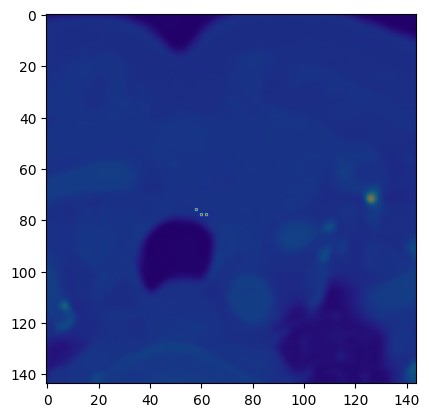

In [41]:
#for i in range(X_test_tensor.shape[0]):
plt.imshow(X_test_tensor[10,:,:])
plt.imshow(pred_np[10], cmap='jet', alpha=0.5)  # Using gray scale color map for visualization
#plt.axis('off')  # Optional: to hide axes for better visualization
plt.show()